## MOM6 data and MOM6 ML model

In [1]:
import sys 
sys.path.append('../modules/')

In [2]:
%reload_ext autoreload
%autoreload 2
import evaluation

2024-02-12 21:13:53.737980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 21:13:53.738007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 21:13:53.738013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MOM6_P2L_all_36_36.nc'
data_kind = 'MOM6_P2L' 
exp_name  = 'P2L' 
ML_name   = 'all'

In [4]:
eval_dic = {}
Lkeys = ['50', '100', '200', '400']
for L in Lkeys: 
    data_zarr = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_'+L+'km.zarr'
    eval_dic[L] = evaluation.full_reader(model_nc, data_zarr, L, data_kind, exp_name, ML_name)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr
Normalized data
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr
Normalized data


In [32]:
eval_dic['50'].output_ds

<xarray.Dataset>
Dimensions:  (Time: 25, yh: 186, xh: 150)
Coordinates:
  * Time     (Time) object 0197-06-21 00:00:00 ... 0198-02-16 00:00:00
  * xh       (xh) float64 4.0 12.0 20.0 28.0 ... 1.18e+03 1.188e+03 1.196e+03
  * yh       (yh) float64 60.0 68.0 76.0 84.0 ... 1.524e+03 1.532e+03 1.54e+03
Data variables:
    Sfnx     (Time, yh, xh) float64 dask.array<chunksize=(25, 186, 150), meta=np.ndarray>
    Sfny     (Time, yh, xh) float64 dask.array<chunksize=(25, 186, 150), meta=np.ndarray>

In [6]:
import matplotlib.pyplot as plt
import numpy as np

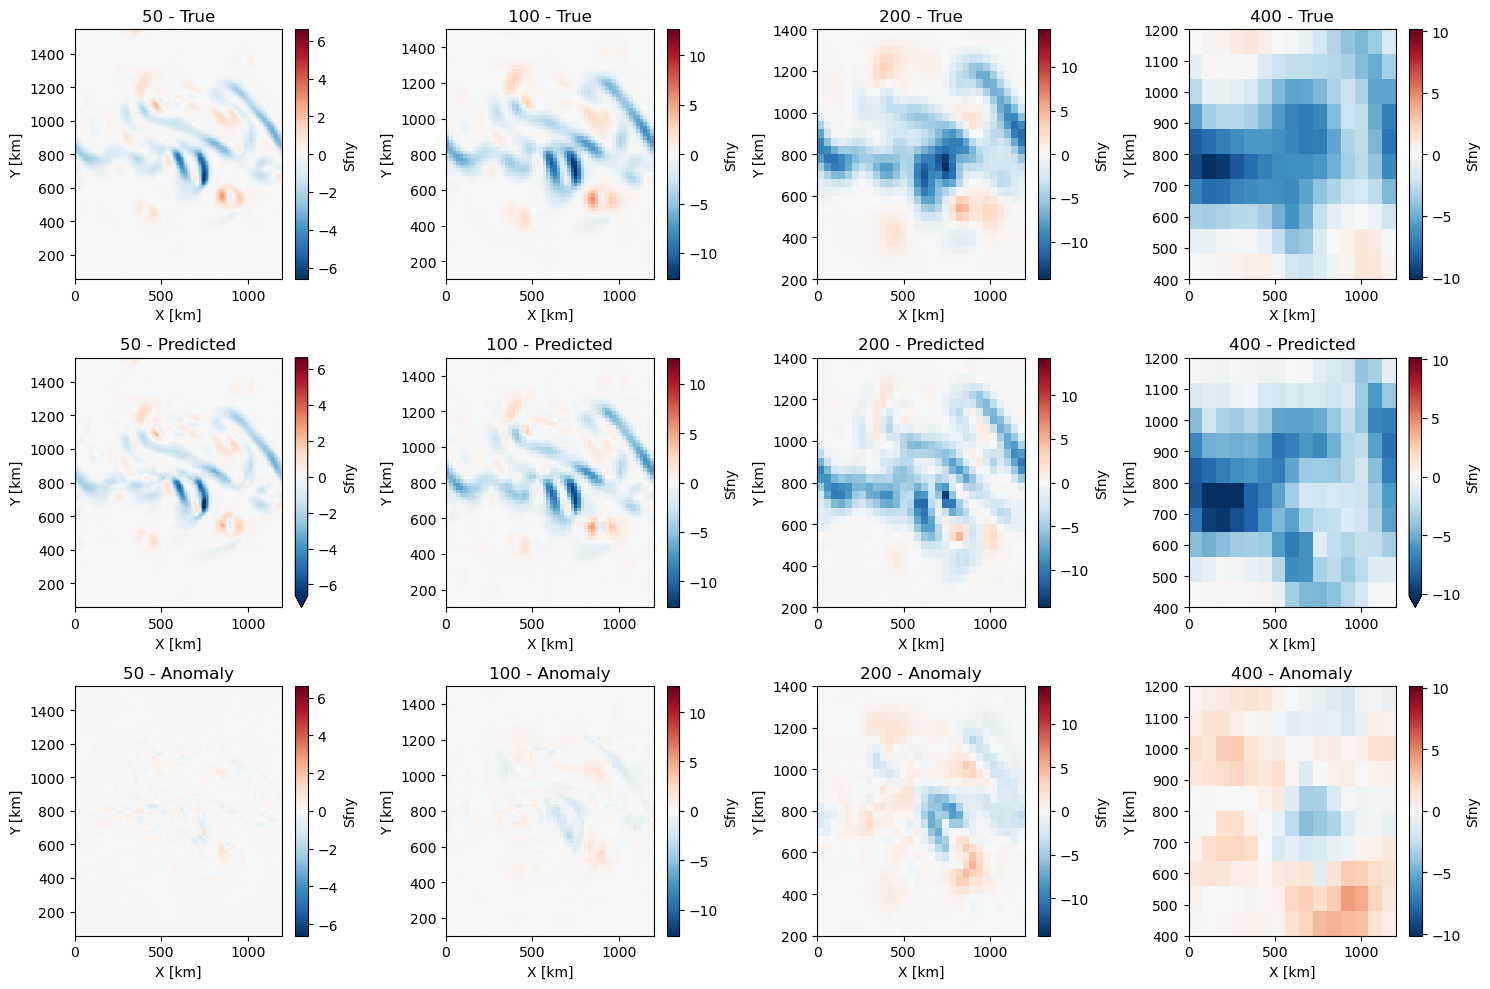

In [7]:
# Create a figure and axis objects
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate through the keys '50km', '100km', '200km', and '400km' and plot each dataset
for i, key in enumerate(['50', '100', '200', '400']):
    values = eval_dic[key]
    ds_true = values.output_ds.Sfny.isel(Time=-1)
    ds_pred = values.output_pred_ds.Sfny.isel(Time=-1)
    ds_anomaly = ds_true - ds_pred

    # Plotting true values
    ds_true.plot(ax=axs[0,i], vmin=ds_true.min().values)
    axs[0,i].set_title(f'{key} - True')
    
    # Plotting predicted values
    ds_pred.plot(ax=axs[1,i], vmin=ds_true.min().values)
    axs[1,i].set_title(f'{key} - Predicted')
    
    # Plotting anomaly values
    ds_anomaly.plot(ax=axs[2,i], vmin=ds_true.min().values)
    axs[2,i].set_title(f'{key} - Anomaly')
    
    # Set title and labels
    for j in range(3):
        axs[j,i].set_xlabel('X [km]')
        axs[j,i].set_ylabel('Y [km]')

    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
#plt.show()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_panels.png')

### Metrics

### Pointwise

In [8]:
Lkeys = ['50', '100', '200', '400']
print('R2:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_R2(dims=['Time','xh','yh']).values) )

R2:
50: 0.9561690001953518
100: 0.9435170317071252
200: 0.8168275033626315
400: 0.656968818214763


In [9]:
Lkeys = ['50', '100', '200', '400']
print('R2:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_R2(dims=['Time','xh','yh']).values) )

R2:
50: 0.9561690001953518
100: 0.9435170317071252
200: 0.8168275033626315
400: 0.656968818214763


In [10]:
Lkeys = ['50', '100', '200', '400']
print('Corr:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_corr(dims=['Time','xh','yh']).values) )

Corr:
50: 0.9785617989817832
100: 0.970642433592056
200: 0.8983042999674811
400: 0.7972162875240458


### Spectral

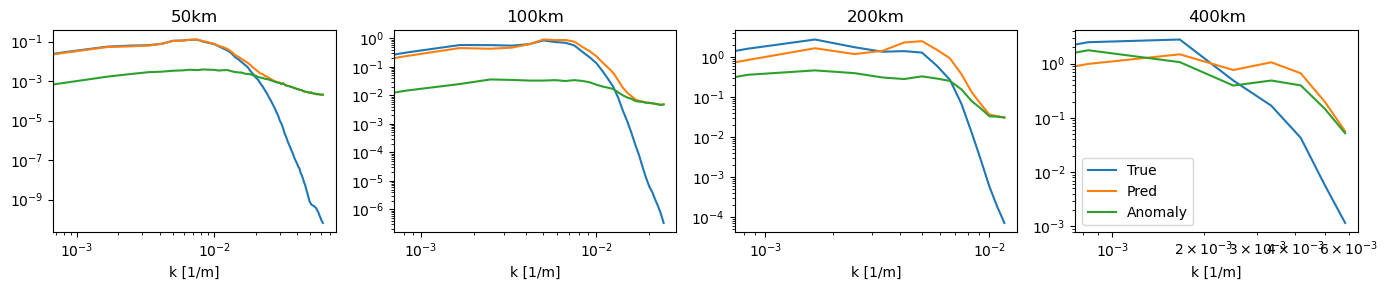

In [11]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_ps, pred_ps, anom_ps = eval_dic[L].zonal_PS_P2L(var='Sfny', 
                                                     avg_dims=['Time','yh'])
    plt.subplot(1,4,i+1)
    (true_ps * true_ps.freq_xh).plot(label='True')
    (pred_ps * pred_ps.freq_xh).plot(label='Pred')
    (anom_ps * anom_ps.freq_xh).plot(label='Anomaly')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k [1/m]')
    plt.title(L+'km')
    
plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_spectra.png')

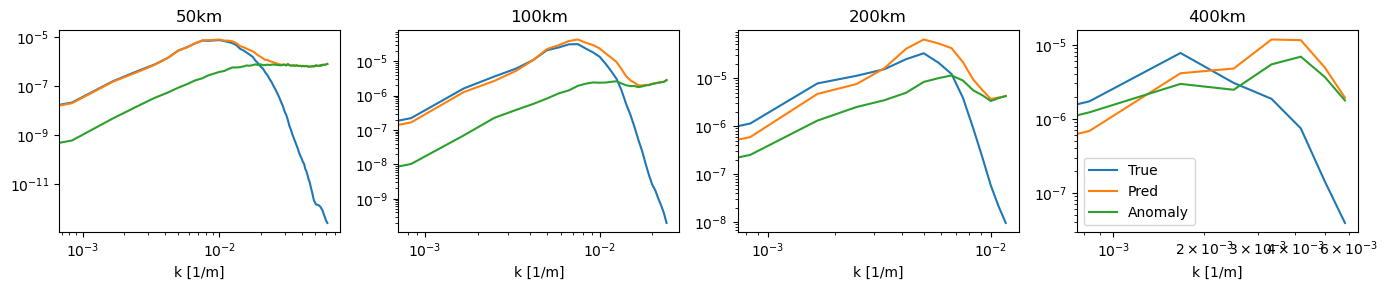

In [12]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_ps, pred_ps, anom_ps = eval_dic[L].zonal_PS_P2L(var='Sfny', 
                                                     avg_dims=['Time','yh'])
    plt.subplot(1,4,i+1)
    (true_ps * true_ps.freq_xh**3).plot(label='True')
    (pred_ps * pred_ps.freq_xh**3).plot(label='Pred')
    (anom_ps * anom_ps.freq_xh**3).plot(label='Anomaly')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k [1/m]')
    plt.title(L+'km')
    
plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_spectra.png')

### Bulk

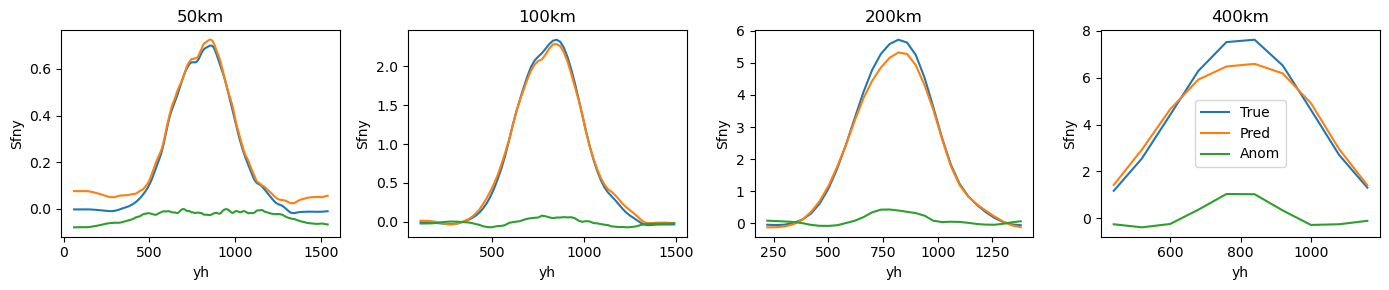

In [13]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_OT, pred_OT, anom_OT = eval_dic[L].zonal_avg_OT(avg_dims=['Time','xh'])
    
    plt.subplot(1,4,i+1)
    (-true_OT).plot(label='True')
    (-pred_OT).plot(label='Pred')
    (-anom_OT).plot(label='Anom')
    plt.title(L+'km')
    
plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MOM6all_OT.png')

## Potential energy evaluation

In [67]:
import xarray as xr
import xrft

In [114]:
L = '100'
ds_filt = eval_dic[L].eval_ds.dataset.isel(Time=slice(-25,None))

In [115]:
ds_filt['e'] = ds_filt.e - ds_filt.e.isel(Time=0).mean(['xh','yh'])

In [116]:
uh_sg_true = ds_filt.uh_sg.isel(zl=1)
vh_sg_true = ds_filt.vh_sg.isel(zl=1)
uh_sg_pred = eval_dic[L].output_pred_ds['Sfnx']
vh_sg_pred = eval_dic[L].output_pred_ds['Sfny']

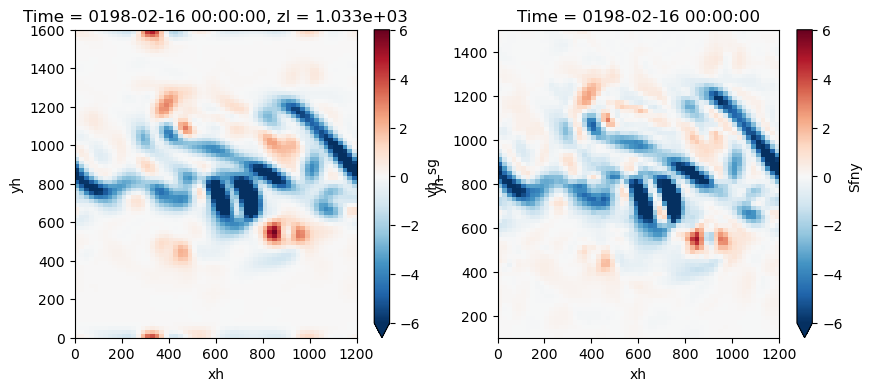

In [117]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
vh_sg_true.isel(Time=-1).plot(vmin=-6)

plt.subplot(122)
vh_sg_pred.isel(Time=-1).plot(vmin=-6)

In [118]:
def div_uphp(uh_sg, vh_sg):
    dx = (uh_sg.xh[1] - uh_sg.xh[0]).values * 1e3
    uh_sg_i = uh_sg
    uh_sg_ip1 = uh_sg.roll(xh=-1)
    
    uh_sg_q = 0.5*(uh_sg_ip1 + uh_sg_i)
    
    uh_sg_q_im1 = uh_sg_q.roll(xh=1)
    
    dx_uh_sg = (uh_sg_q - uh_sg_q_im1)/dx 
    
    dy = (uh_sg.yh[1] - uh_sg.yh[0]).values *1e3
    vh_sg_i = vh_sg
    vh_sg_ip1 = vh_sg.roll(yh=-1)
    
    vh_sg_q = 0.5*(vh_sg_ip1 + vh_sg_i)
    
    vh_sg_q_im1 = vh_sg_q.roll(yh=1)
    
    dy_vh_sg = (vh_sg_q - vh_sg_q_im1)/dy

    return dx_uh_sg, dy_vh_sg, dx_uh_sg + dy_vh_sg

In [119]:
dx_uh_sg_true, dy_vh_sg_true, div_uh_sg_true  = div_uphp(uh_sg_true, vh_sg_true)
dx_uh_sg_pred, dy_vh_sg_pred, div_uh_sg_pred  = div_uphp(uh_sg_pred, vh_sg_pred)

In [120]:
ds_filt['div_uh_sg_true'] = div_uh_sg_true
ds_filt['div_uh_sg_pred'] = div_uh_sg_pred

In [121]:
eta_tend_true = np.zeros_like(ds_filt.e)
eta_tend_pred = np.zeros_like(ds_filt.e)

eta_tend_true[:,1,:,:] = - ds_filt['div_uh_sg_true']
eta_tend_pred[:,1,:,:] = - ds_filt['div_uh_sg_pred']

ds_filt['eta_tend_true'] = xr.DataArray(eta_tend_true, dims=ds_filt.e.dims)
ds_filt['eta_tend_pred'] = xr.DataArray(eta_tend_pred, dims=ds_filt.e.dims)

In [122]:
def PE_tend(ds, var = 'dt_eta'): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    PE_tend_i = (ds.gr * ds.e * ds[var])
    PE_tend = (ds.gr * ds.e * ds[var]).sum('zi')
    

    return PE_tend, PE_tend_i

In [123]:
def PE_tend_spectral(ds, var = 'dt_eta'): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    #e_dft = xrft.dft(ds.e, dim='xh', true_phase=True, true_amplitude=True)
    #var_dft = xrft.dft(ds[var], dim='xh', true_phase=True, true_amplitude=True)

    e_dft = xrft.dft(ds.e, dim='xh', true_phase=True, true_amplitude=True)
    var_dft = xrft.dft(ds[var], dim='xh', true_phase=True, true_amplitude=True)
    
    PE_tend_i = (ds.gr * e_dft * np.conjugate(var_dft)).real
    PE_tend = PE_tend_i.sum('zi')
    
    return PE_tend, PE_tend_i

In [124]:
ds_filt['dt_eta_mean_by_eddy_true'], _ = PE_tend(ds_filt,'eta_tend_true')
ds_filt['dt_eta_mean_by_eddy_pred'], _ = PE_tend(ds_filt,'eta_tend_pred')

In [125]:
ds_filt['dt_eta_mean_by_eddy_true_spectral'], _ = PE_tend_spectral(ds_filt,'eta_tend_true')
ds_filt['dt_eta_mean_by_eddy_pred_spectral'], _ = PE_tend_spectral(ds_filt,'eta_tend_pred')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'MPE tend eddy [k]')

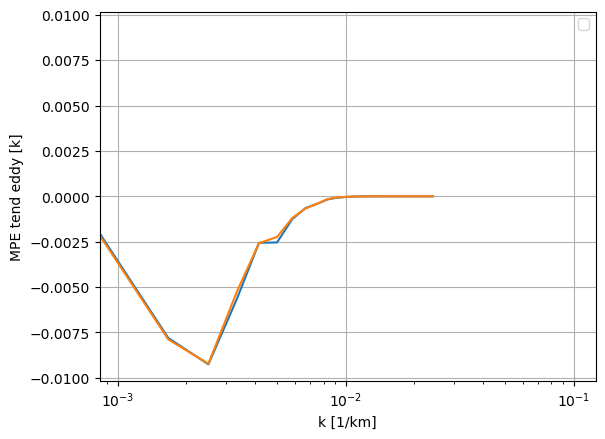

In [130]:

(ds_filt['dt_eta_mean_by_eddy_true_spectral'] * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
(ds_filt['dt_eta_mean_by_eddy_pred_spectral'] * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

Text(0, 0.5, 'MPE tend eddy [k]')

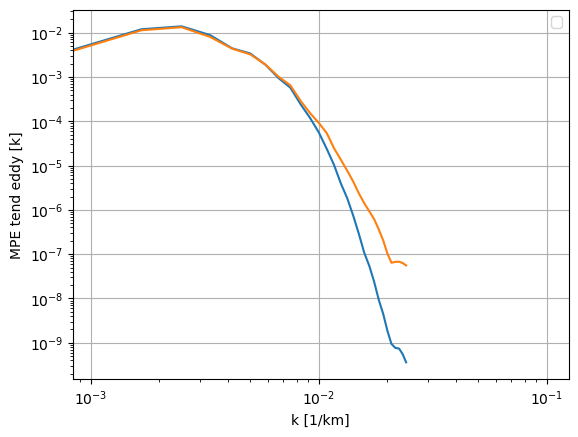

In [131]:

(np.abs(ds_filt['dt_eta_mean_by_eddy_true_spectral']) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
(np.abs(ds_filt['dt_eta_mean_by_eddy_pred_spectral']) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

Text(0, 0.5, 'MPE tend eddy [k]')

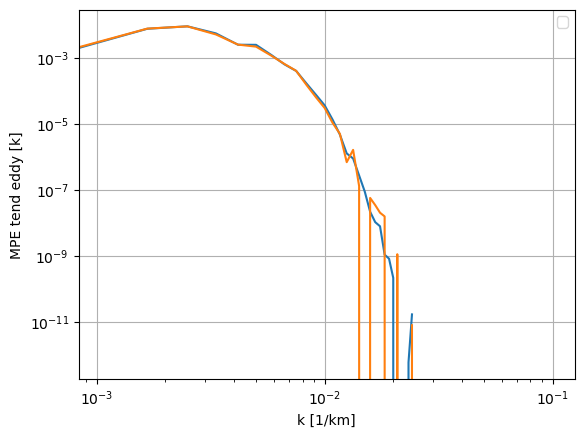

In [132]:

(-(ds_filt['dt_eta_mean_by_eddy_true_spectral']) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
(-(ds_filt['dt_eta_mean_by_eddy_pred_spectral']) * ds_filt.freq_xh).sel(yh=slice(400, 1200)).mean(['Time','yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('k [1/km]')
plt.legend()
plt.ylabel('MPE tend eddy [k]')

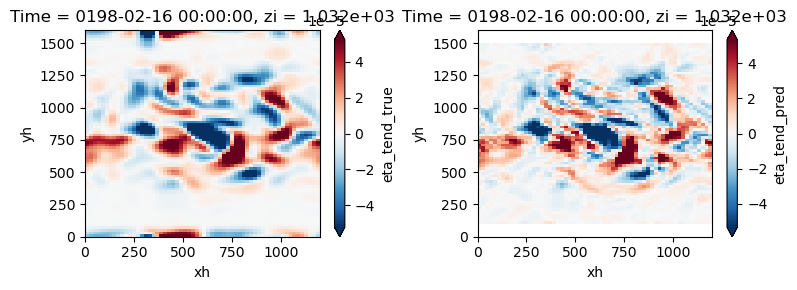

In [127]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_filt.eta_tend_true.isel(Time=-1, zi=1).plot(robust=True)

plt.subplot(122)
ds_filt.eta_tend_pred.isel(Time=-1, zi=1).plot(robust=True)

plt.tight_layout()

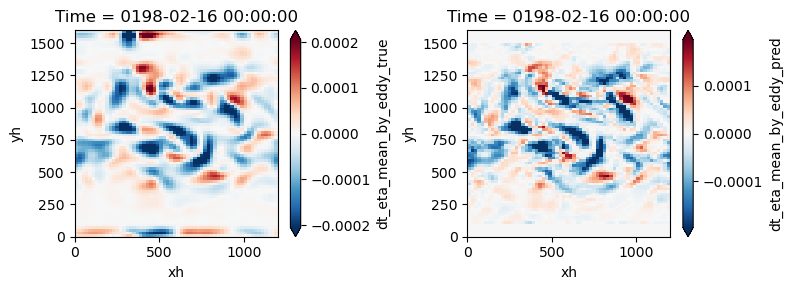

In [128]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_filt.dt_eta_mean_by_eddy_true.isel(Time=-1).plot(robust=True)

plt.subplot(122)
ds_filt.dt_eta_mean_by_eddy_pred.isel(Time=-1).plot(robust=True)

plt.tight_layout()

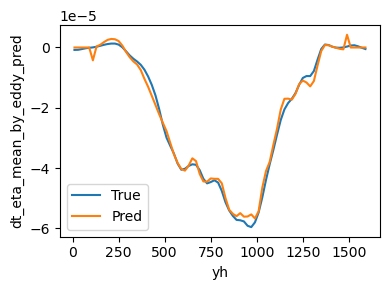

In [129]:
plt.figure(figsize=(4, 3))

ds_filt.dt_eta_mean_by_eddy_true.mean('Time').mean('xh').plot(label='True')
ds_filt.dt_eta_mean_by_eddy_pred.mean('Time').mean('xh').plot(label='Pred')

plt.legend()
plt.tight_layout()

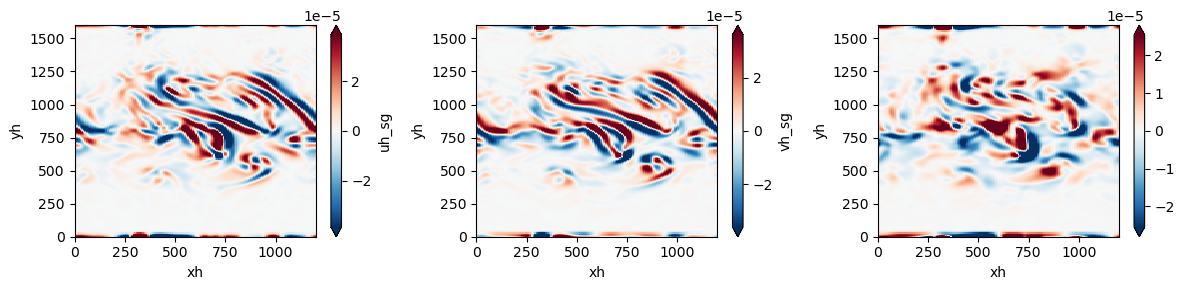

In [54]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
(dx_uh_sg_true ).isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(132)
(dy_vh_sg_true).isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(133)
div_uh_sg_true.isel(Time=-1).plot(robust=True)
plt.title('')

plt.tight_layout()

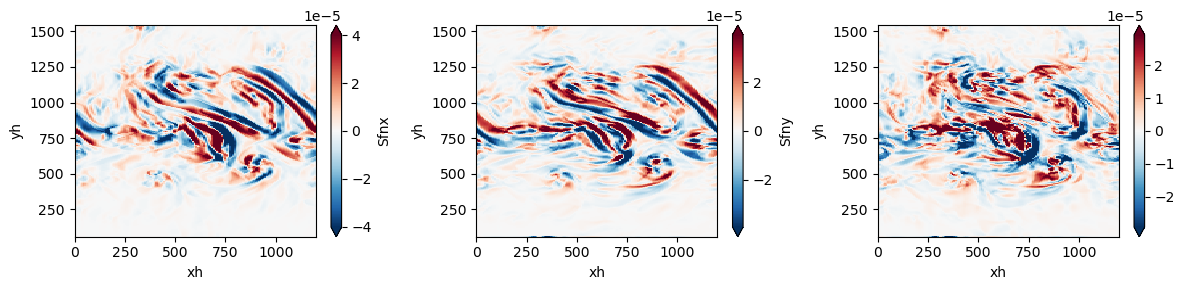

In [56]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
(dx_uh_sg_pred ).isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(132)
(dy_vh_sg_pred).isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(133)
div_uh_sg_pred.isel(Time=-1).plot(robust=True)
plt.title('')

plt.tight_layout()

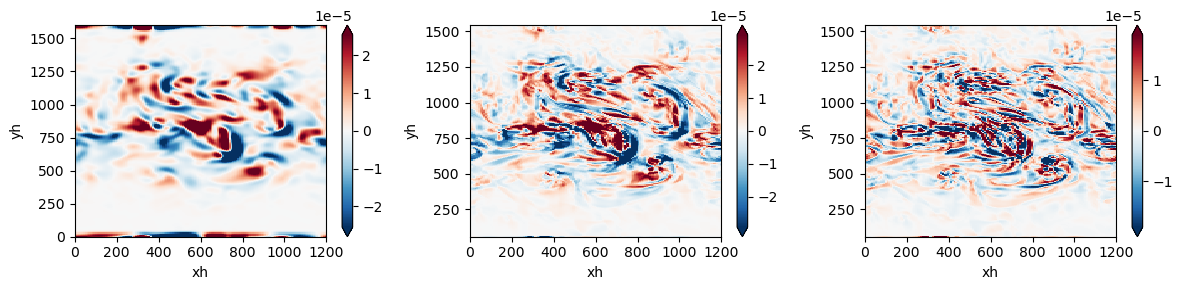

In [57]:

plt.figure(figsize=(12, 3))

plt.subplot(131)
div_uh_sg_true.isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(132)
div_uh_sg_pred.isel(Time=-1).plot(robust=True)
plt.title('')

plt.subplot(133)
(div_uh_sg_true - div_uh_sg_pred).isel(Time=-1).plot(robust=True)
plt.title('')

plt.tight_layout()